In [2]:
import cirq
import matplotlib.pyplot as plt
import sinter
import stim
from stimcirq import cirq_circuit_to_stim_circuit

from tqec.constructions.qubit import ScalableQubitSquare
from tqec.detectors.gate import ShiftCoordsGate
from tqec.detectors.transformer import fill_in_global_record_indices
from tqec.enums import PlaquetteOrientation
from tqec.generation.circuit import generate_circuit
from tqec.noise_models import (
    AfterCliffordDepolarizingNoise,
    AfterResetFlipNoise,
    BeforeMeasurementFlipNoise,
)
from tqec.plaquette.library import (
    XXXXPlaquette,
    ZZZZPlaquette,
)
from tqec.plaquette.library.xx import XXPlaquette
from tqec.plaquette.library.zz import ZZPlaquette
from tqec.detectors.gate import ObservableGate, RelativeMeasurement
from tqec.position import Shape2D

In [3]:
def normalise_circuit(circuit: cirq.Circuit) -> cirq.Circuit:
    ordered_transformers = [
        cirq.drop_empty_moments,
    ]
    for transformer in ordered_transformers:
        circuit = transformer(circuit)
    return circuit


def to_noisy_circuit(circuit: cirq.Circuit, noise_level: float) -> cirq.Circuit:
    noise_models = [
        AfterCliffordDepolarizingNoise(noise_level),
        AfterResetFlipNoise(noise_level),
        BeforeMeasurementFlipNoise(noise_level),
    ]
    for nm in noise_models:
        circuit = circuit.with_noise(nm)
    return circuit

In [4]:
def generate_cirq_circuit_tqec(dimension: int, repetitions: int) -> cirq.Circuit:
    """Constructing the error-corrected qubit in https://doi.org/10.1038/s41586-022-05434-1."""
    template = ScalableQubitSquare(dimension)
    plaquettes = [
        ZZPlaquette(PlaquetteOrientation.UP),
        XXPlaquette(
            PlaquetteOrientation.LEFT, include_initial_and_final_detectors=False
        ),
        ZZZZPlaquette(),
        XXXXPlaquette(include_initial_and_final_detectors=False),
        XXPlaquette(
            PlaquetteOrientation.RIGHT, include_initial_and_final_detectors=False
        ),
        ZZPlaquette(PlaquetteOrientation.DOWN),
    ]

    def make_repeated_layer(circuit: cirq.Circuit) -> cirq.Circuit:
        any_qubit = next(iter(circuit.all_qubits()), None)
        assert (
            any_qubit is not None
        ), "Could not find any qubit in the given Circuit instance."
        circuit_to_repeat = (
            cirq.Circuit([ShiftCoordsGate(0, 0, 1).on(any_qubit)]) + circuit
        )
        repeated_circuit_operation = cirq.CircuitOperation(
            circuit_to_repeat.freeze()
        ).repeat(repetitions)
        return cirq.Circuit([repeated_circuit_operation])

    layer_modificators = {1: make_repeated_layer}

    circuit = cirq.Circuit()
    for layer_index in range(3):
        layer_circuit = generate_circuit(template, plaquettes, layer_index=layer_index)
        layer_circuit = normalise_circuit(layer_circuit)
        circuit += layer_modificators.get(layer_index, lambda circ: circ)(layer_circuit)

    # Compute the qubits that should be measured to get the Z logical operator.
    plaquette_shape: Shape2D = plaquettes[0].shape
    assert all(
        p.shape == plaquette_shape for p in plaquettes
    ), "All plaquettes should have exactly the same shape for the moment."
    origin = cirq.GridQubit(plaquette_shape.y - 1, plaquette_shape.x - 1)
    circuit.append(
        [
            ObservableGate(
                origin,
                [
                    RelativeMeasurement(
                        cirq.GridQubit(0, i * (plaquette_shape.y - 1)), -1
                    )
                    for i in range(dimension + 1)
                ],
            ).on(origin)
        ]
    )

    circuit_with_detectors = fill_in_global_record_indices(circuit)
    return circuit_with_detectors

In [5]:
def generate_stim_circuit_tqec(
    code_distance: int, noise_level: float, repetitions: int
) -> stim.Circuit:
    circuit_with_detectors = generate_cirq_circuit_tqec(code_distance - 1, repetitions)
    noisy_circuit = to_noisy_circuit(circuit_with_detectors, noise_level)

    return cirq_circuit_to_stim_circuit(noisy_circuit)

In [6]:
stim_circuit_tqec = generate_stim_circuit_tqec(3, 0.001, 2)

In [7]:
def generate_stim_circuit_stim(
    code_distance: int, noise_level: float, repetitions: int
) -> stim.Circuit:
    return stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=repetitions + 1,
        distance=code_distance,
        after_clifford_depolarization=noise_level,
        after_reset_flip_probability=noise_level,
        before_measure_flip_probability=noise_level,
        before_round_data_depolarization=0,
    )

In [8]:
stim_circuit_stim = generate_stim_circuit_stim(3, 0.001, 2)

In [9]:
export_stim_files = True
if export_stim_files:
    with open("./stim.stim", "w") as f:
        f.write(str(stim_circuit_stim))
    with open("./tqec.stim", "w") as f:
        f.write(str(stim_circuit_tqec))
    print("Export done!")

Export done!


In [10]:
with open("./tqec.stim", "r") as f:
    stim_circuit_tqec_file = stim.Circuit(f.read())

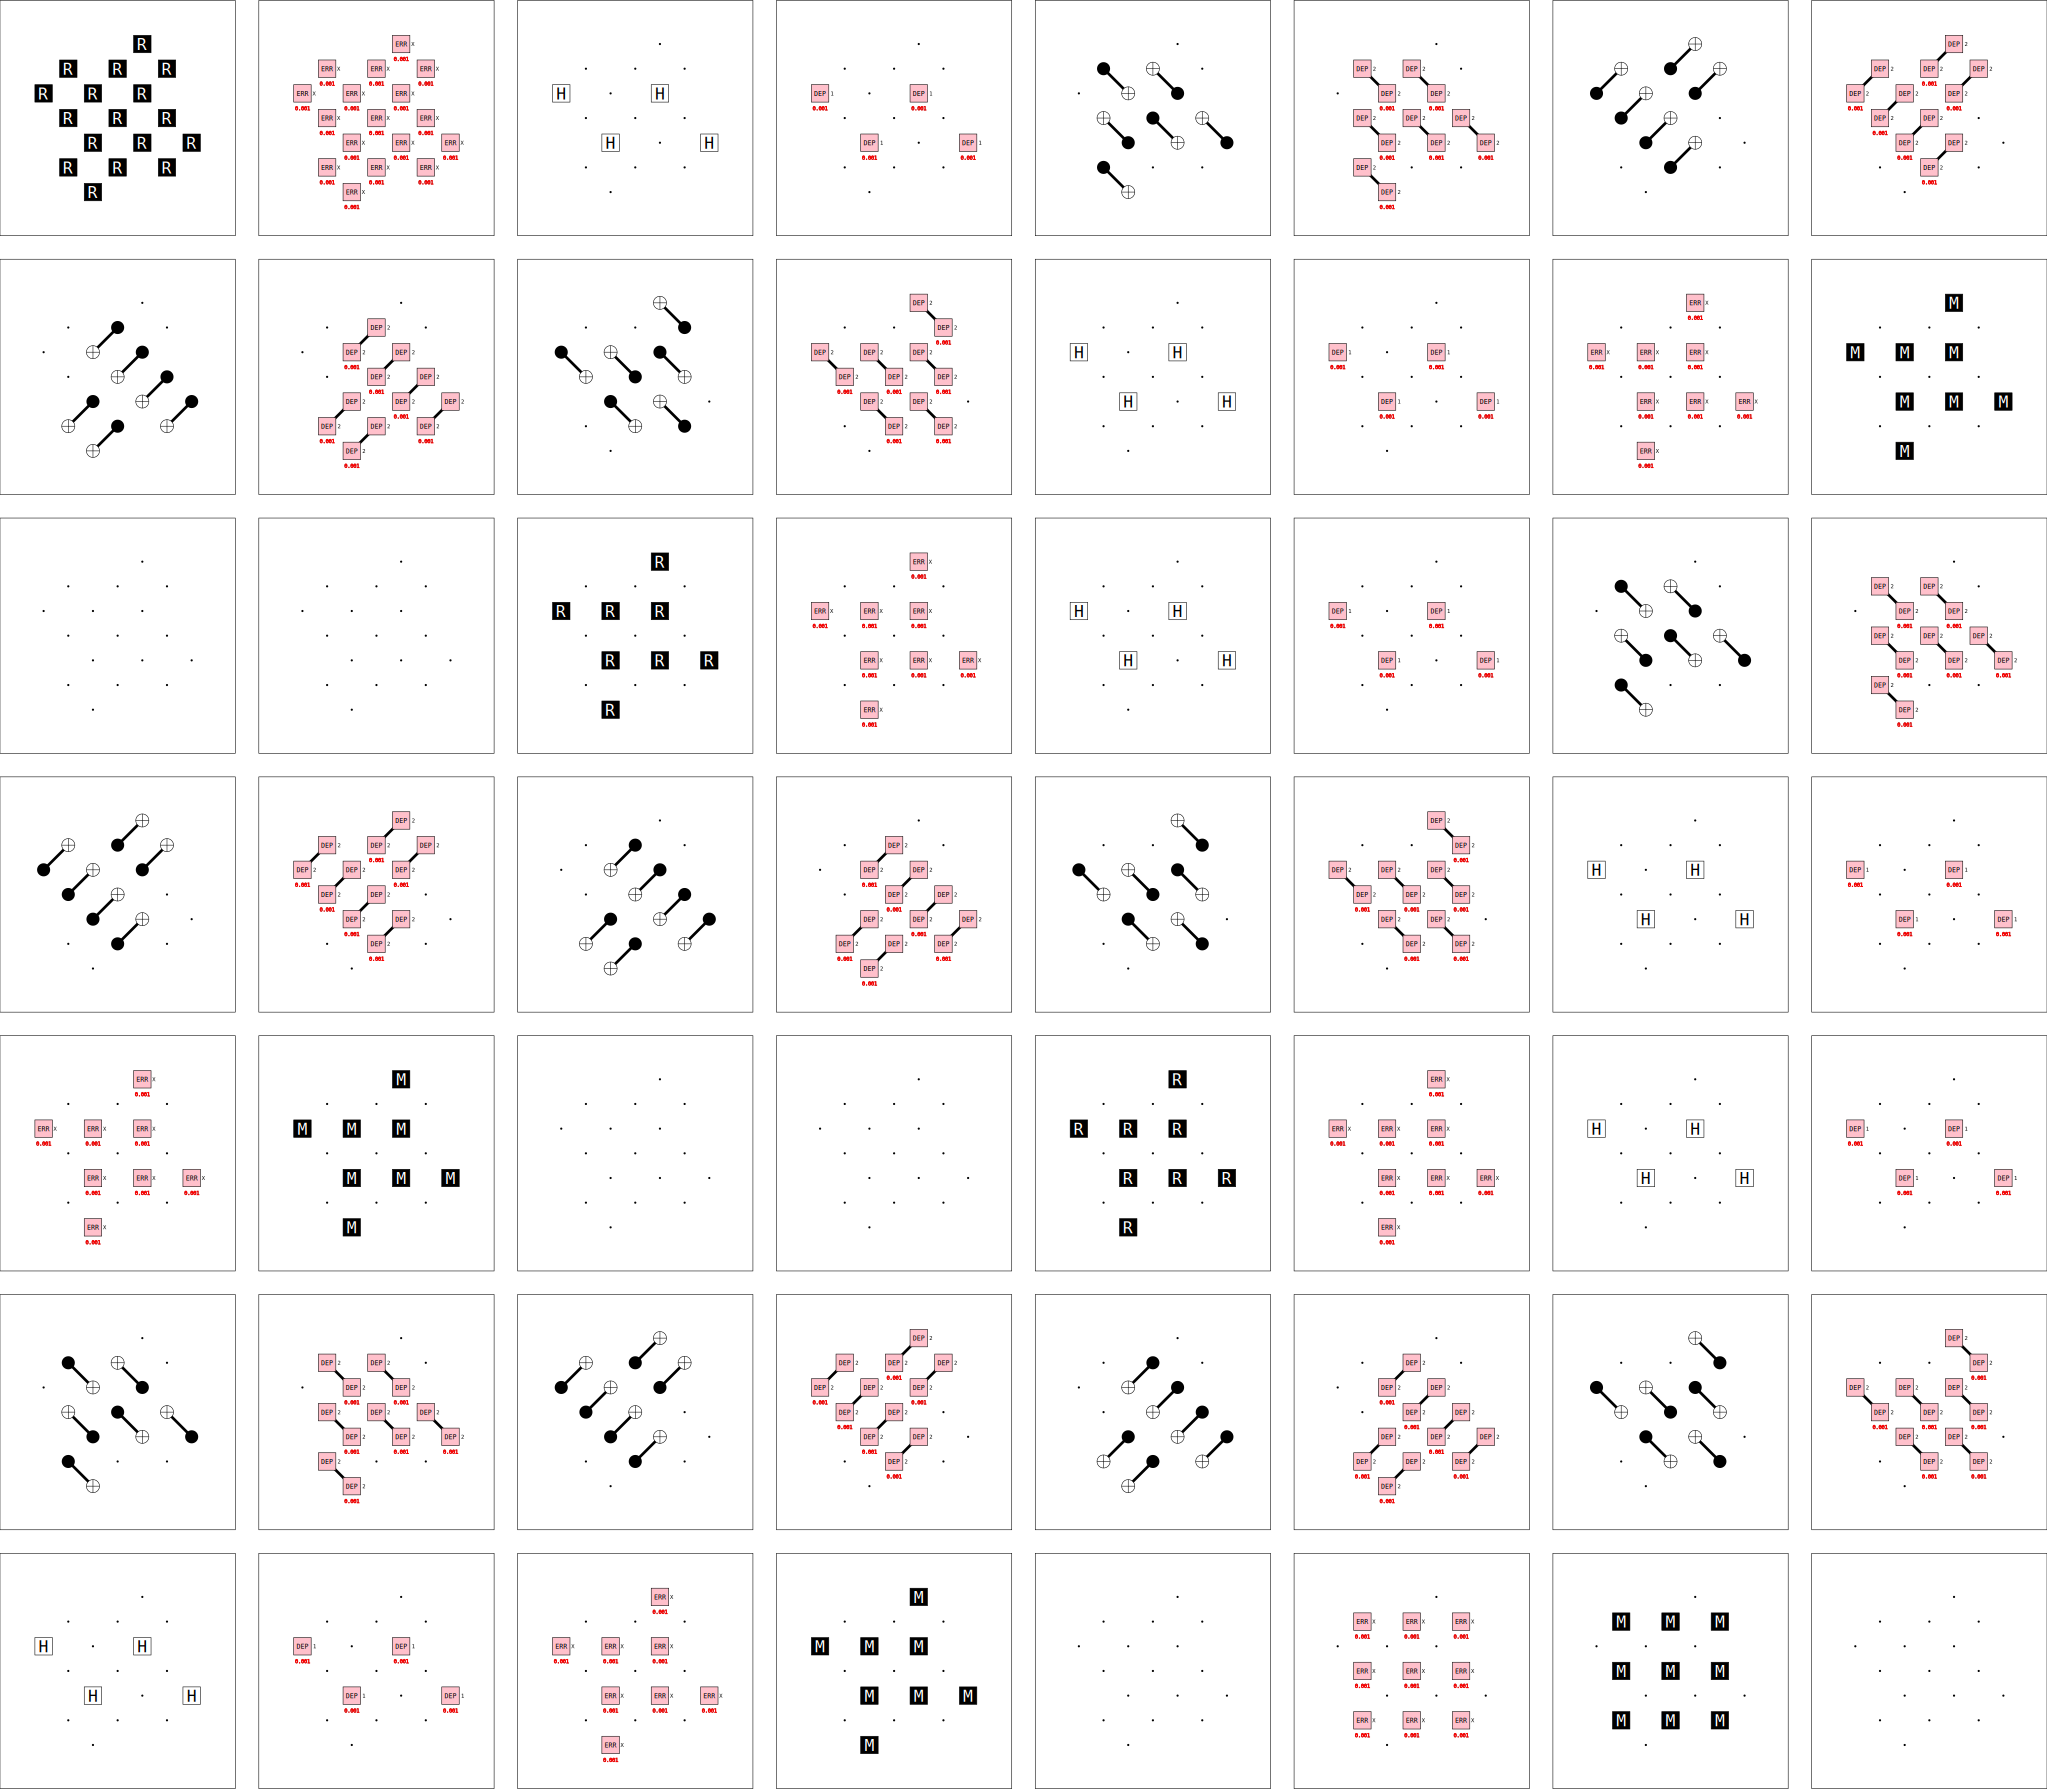

In [11]:
stim_circuit_tqec_file.diagram("timeslice-svg")

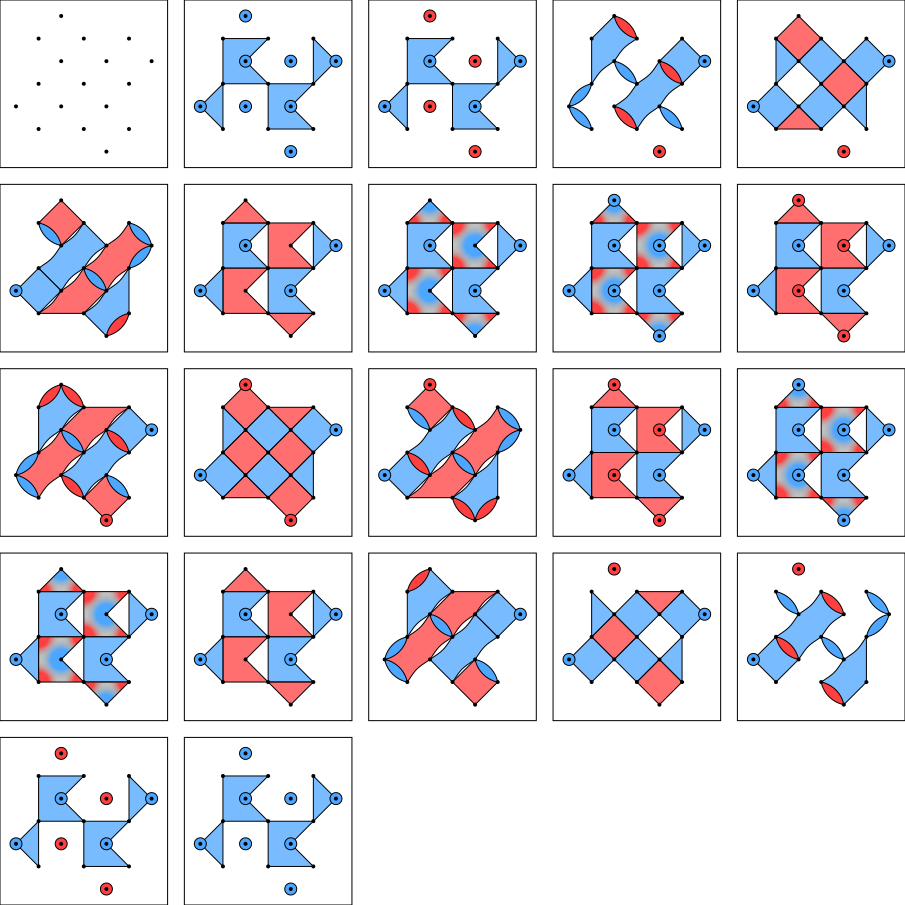

In [13]:
stim_circuit_stim.diagram("detslice-svg")

## TQEC plots

In [29]:
surface_code_tasks_tqec = [
    sinter.Task(
        circuit=generate_stim_circuit_tqec(d, noise, 3 * d),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014]
]

collected_surface_code_stats_tqec: list[sinter.TaskStats] = sinter.collect(
    num_workers=20,
    tasks=surface_code_tasks_tqec,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=False,
)

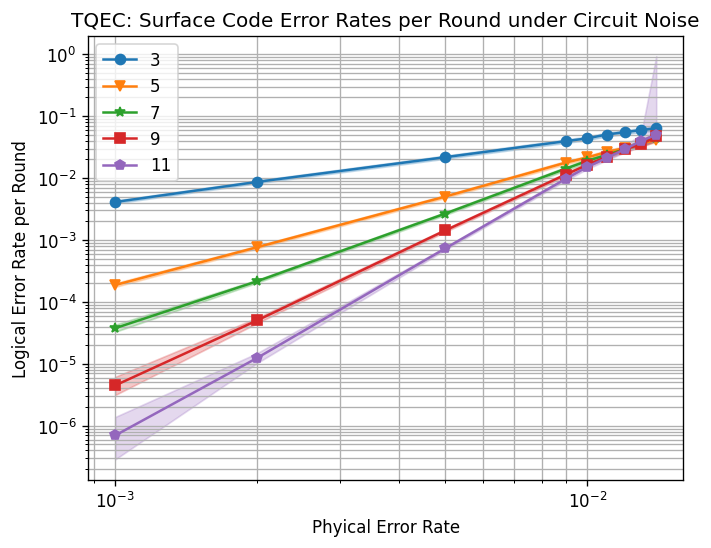

In [30]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_tqec,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("TQEC: Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger

## Stim plots

In [31]:
surface_code_tasks_stim = [
    sinter.Task(
        circuit=generate_stim_circuit_stim(d, noise, 3 * d),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014]
]

collected_surface_code_stats_stim: list[sinter.TaskStats] = sinter.collect(
    num_workers=20,
    tasks=surface_code_tasks_stim,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=False,
)

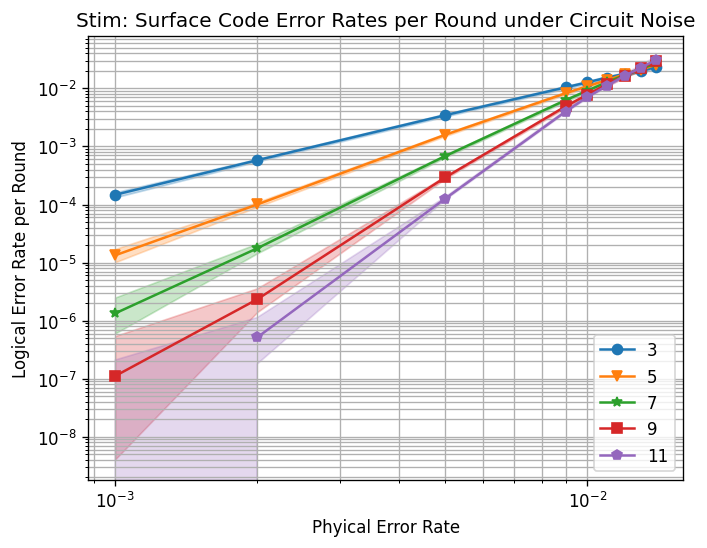

In [32]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_stim,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("Stim: Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [33]:
print(str(stim_circuit_stim))

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.001) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.001) 2 9 11 13 14 16 18 25
TICK
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.001) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.001) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
TICK
X_ERROR(0.001) 2 9 11 13 14 16 18 25
MR 2 9